 # DL기반 시계열 모델링

 * 아래 코드는 데이터파일(data2.pkl)을 로딩해서 돌려야 합니다.
 * 미니프로젝트 진행을 위해 참조로 제공되는 파일입니다.
     * 해당 내용을 모두 실행해야만 하는 것은 아닙니다.
     * 모델은 기본 구성만 코드로 작성하였습니다.



# 1.환경준비

## (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, GlobalMaxPool1D
from keras.optimizers import Adam

import joblib

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [ ]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [ ]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [ ]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 2차원 --> 3차원 변환(for LSTM, CNN) ★

In [ ]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

### 5) 스케일링을 위한 함수 - 얘 말고 그냥 배운거 쓰면 됨 ★
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## (3) 데이터 불러오기

In [ ]:
data2 = joblib.load('data2.pkl')

# 2.전처리1

## (1) 데이터 분할

### 1) x, y 나누기

* .values(넘파이 어레이)로 변환해서 저장하는 이유 ➡ 데이터 스플릿 index를 적용해서 데이터를 가져오기 위해서

In [ ]:
target = 'y'

x = data2.drop([target, 'Datetime'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [ ]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 스케일링

In [ ]:
# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

In [ ]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# 3.모델링1 : DNN

## (1) 학습 및 예측

* 설계

In [ ]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
29/29 [==============================] - 3s 11ms/step - loss: 0.2235 - val_loss: 0.0552
Epoch 2/50
29/29 [==============================] - 0s 9ms/step - loss: 0.0817 - val_loss: 0.0406
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0242
Epoch 4/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0358 - val_loss: 0.0169
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0243 - val_loss: 0.0133
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0104
Epoch 7/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0098
Epoch 8/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0084
Epoch 9/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0088
Epoch 10/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0083
Epoch 11/50
29/29 

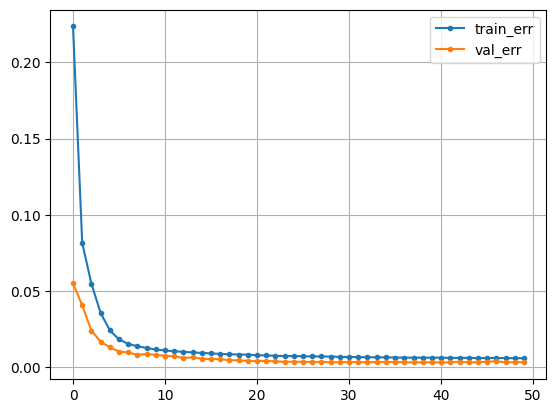

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [ ]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 2ms/step


## (2) 평가

### 1) 검증성능

In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 172.51824136220273
MAPE: 0.2397902075024767
R2  : 0.7923766430951442


### 2) 잔차진단

In [ ]:
# train에 대한 잔차 진단.
pred_tr = model1.predict(x_train_s2)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

36/36 [==============================] - 0s 2ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


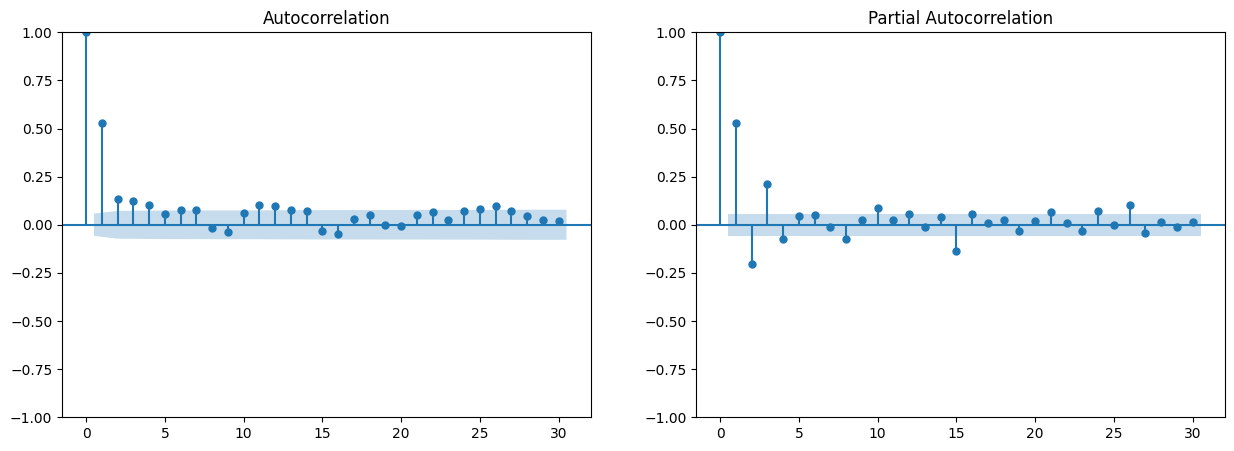

In [ ]:
residual_diag(residuals)

### 3) 결과 시각화

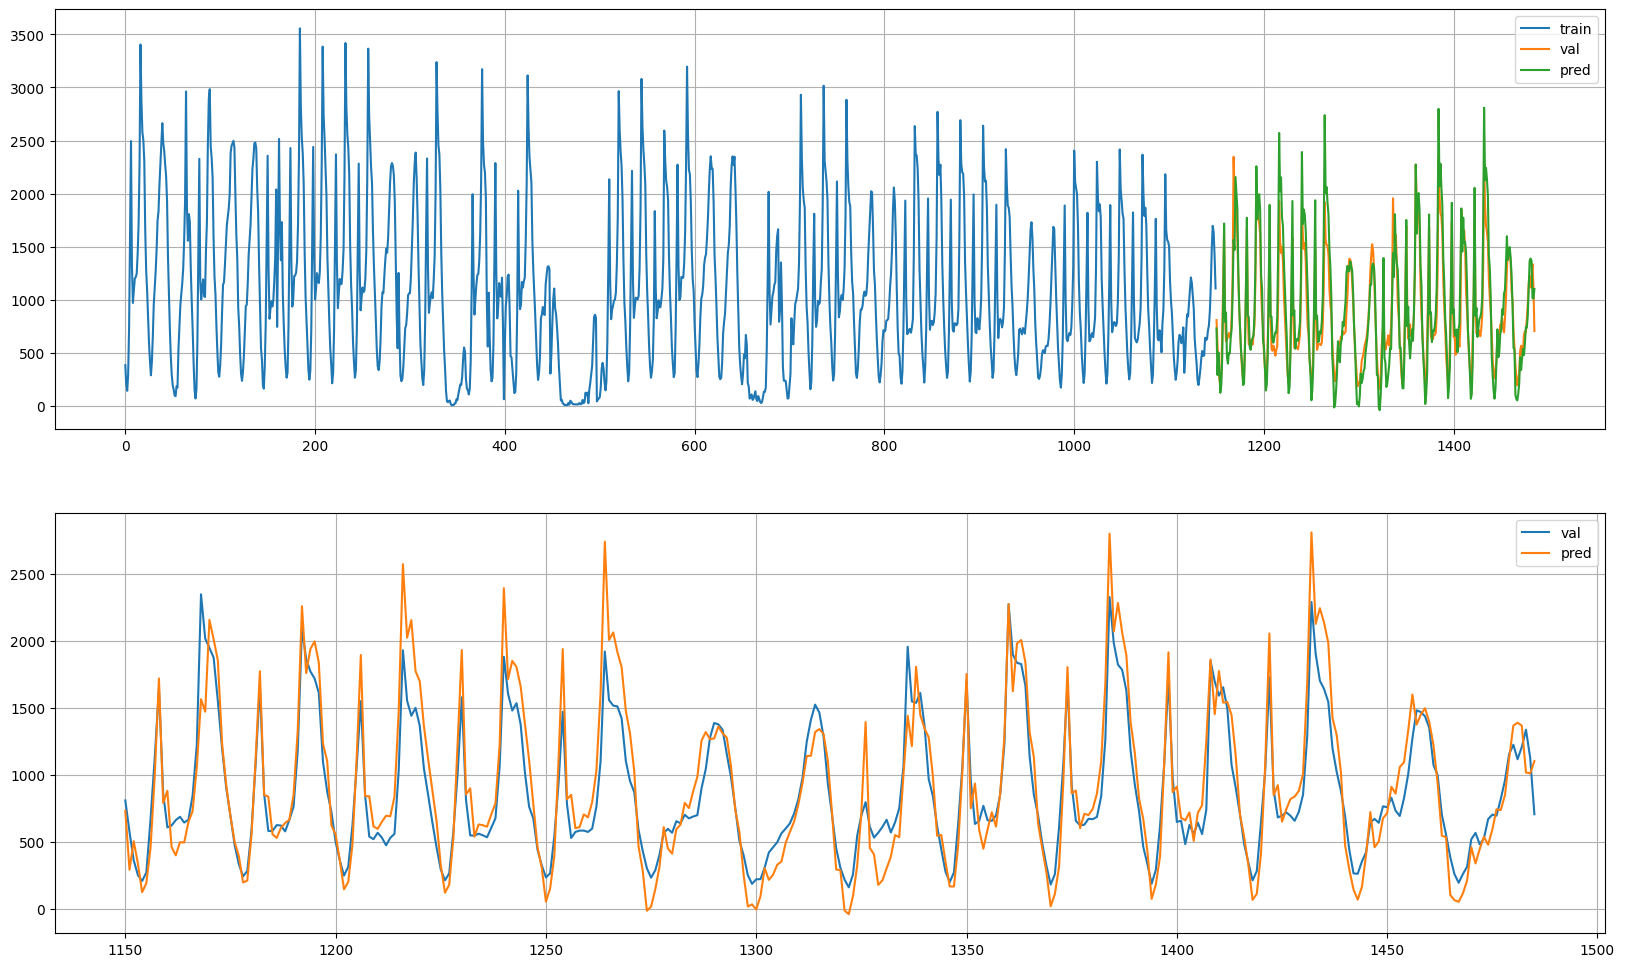

In [ ]:
plot_model_result(y_train, y_val, pred)

# 4.전처리2

## (1) 3차원 구조로 만들기

In [ ]:
timesteps = 24
x2, y2 = temporalize(x, y, timesteps)

## (2) 시계열 데이터 분할

In [ ]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

# 5.모델링2 : LSTM

## (1) 3차원 데이터셋 전처리 : 스케일링

In [ ]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

In [ ]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

## (2) 학습 및 예측

* 설계

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    Dense(1)])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

* 학습

In [ ]:
x_train_s3.shape, y_train_s3.shape

((1127, 24, 12), (1127, 1))

In [ ]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
29/29 [==============================] - 3s 20ms/step - loss: 0.0745 - val_loss: 0.0151
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0108
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0102
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0045
Epoch 6/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 7/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 8/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 9/30
29/29 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 10/30
29/29 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 11/30
29/29 

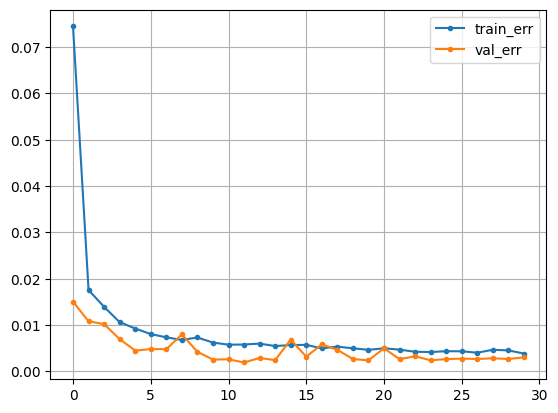

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [ ]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 2ms/step


## (3) 평가

### 1) 검증성능

In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 164.62275072648413
MAPE: 0.22731991381121053
R2  : 0.7963939694045163


### 2) 잔차진단

In [ ]:
# train에 대한 잔차 진단.
pred_tr = model2.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

36/36 [==============================] - 0s 2ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


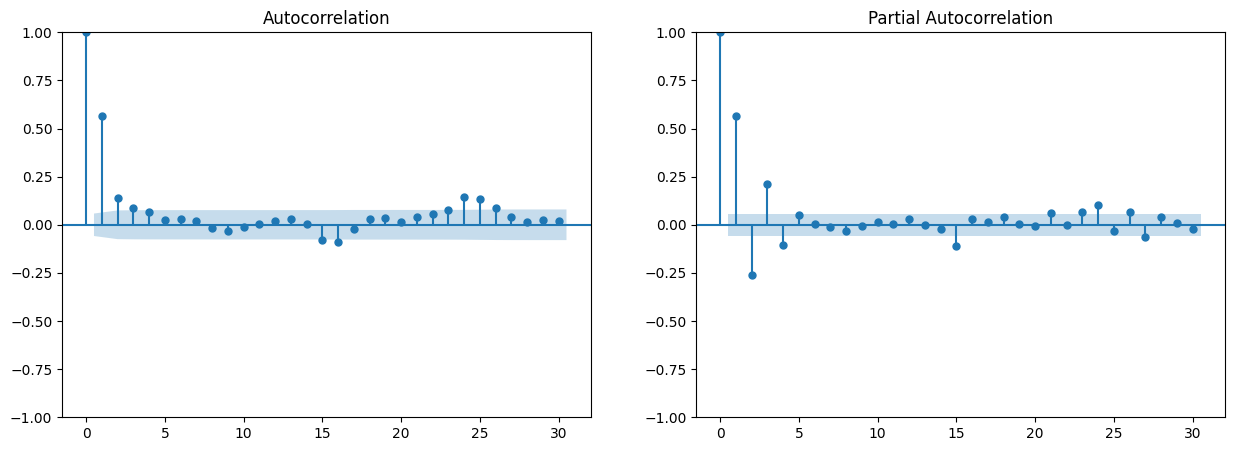

In [ ]:
residual_diag(residuals)

### 3) 결과 시각화

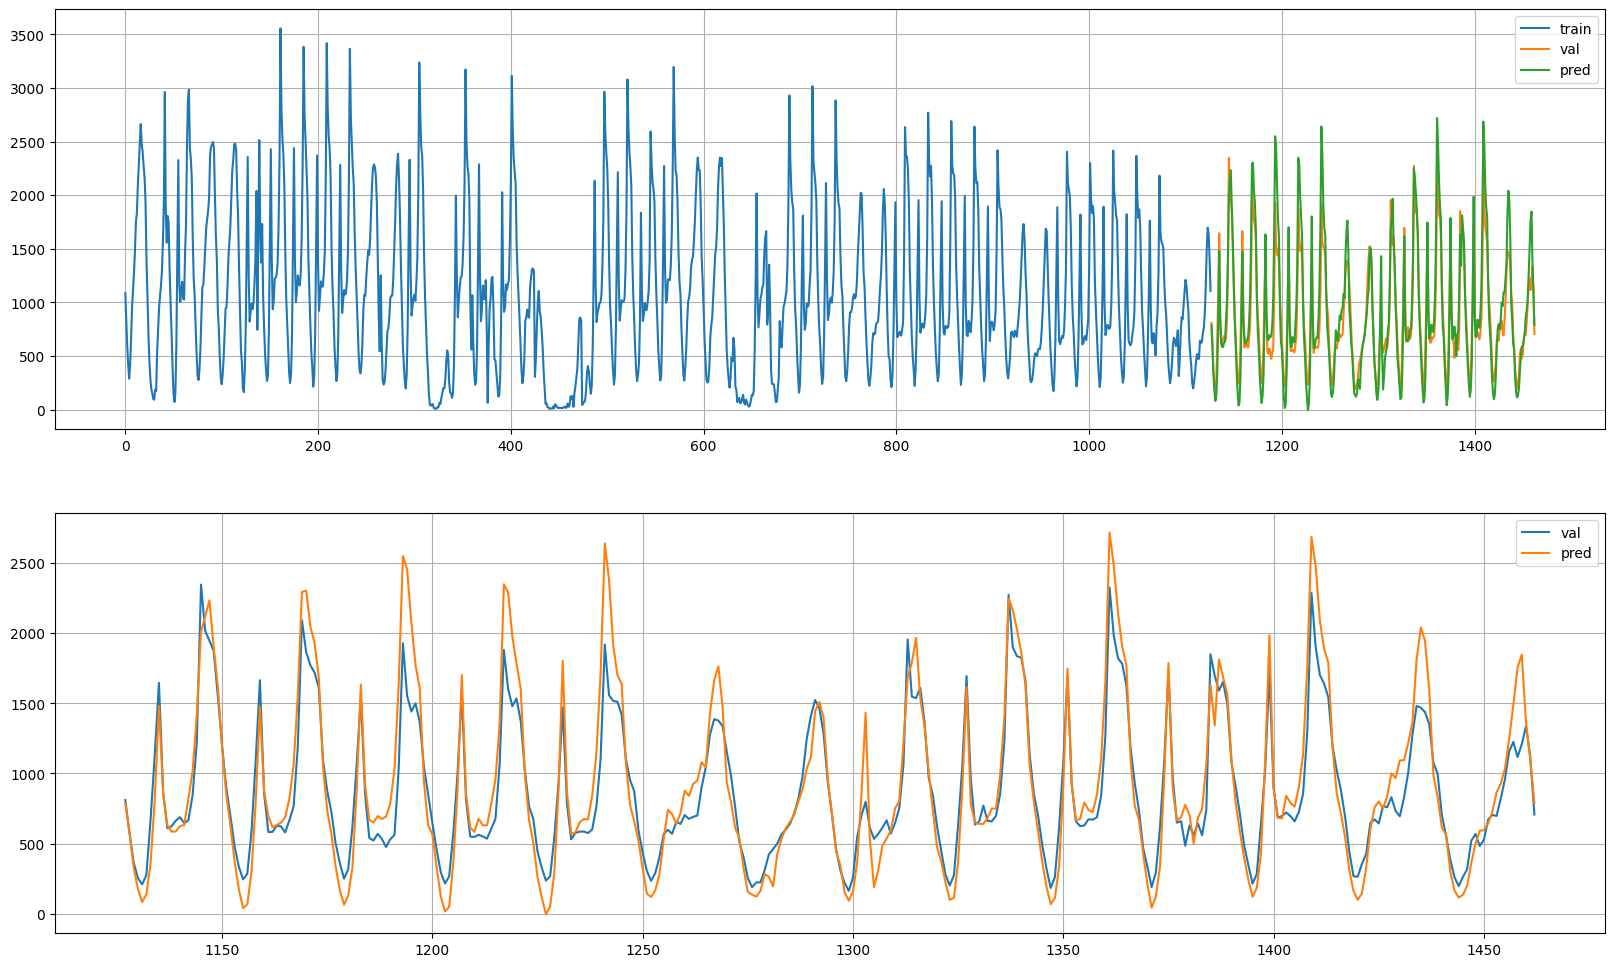

In [ ]:
plot_model_result(y_train, y_val, pred)

# 6.모델링3 : CNN

## (1) 학습 및 예측

* 설계

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'), # (Kernel 32열, Kernel (5행), strides defalut는 1, padding은 그냥 same으로 줘야 같은 사이즈 나옴)
                    Flatten(), # 마지막 Dense 레이어와 연결하기 전에 꼭 해줘야 함
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

* 학습

In [ ]:
x_train_s3.shape, y_train_s3.shape

((1127, 24, 12), (1127, 1))

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
29/29 [==============================] - 4s 41ms/step - loss: 0.2256 - val_loss: 0.0305
Epoch 2/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0266 - val_loss: 0.0080
Epoch 3/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0188 - val_loss: 0.0258
Epoch 4/30
29/29 [==============================] - 0s 12ms/step - loss: 0.0143 - val_loss: 0.0081
Epoch 5/30
29/29 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0133
Epoch 6/30
29/29 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0079
Epoch 7/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 8/30
29/29 [==============================] - 0s 9ms/step - loss: 0.0106 - val_loss: 0.0075
Epoch 9/30
29/29 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 10/30
29/29 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 11/30
2

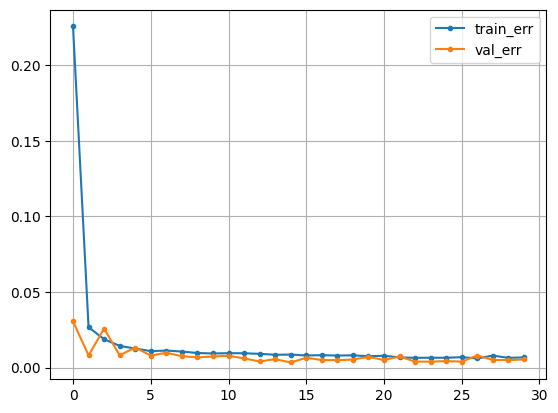

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 8ms/step


## (2) 평가

### 1) 검증성능

In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 231.08114317485266
MAPE: 0.33049722972983336
R2  : 0.6564423320072507


### 2) 잔차진단

In [ ]:
# train에 대한 잔차 진단.
pred_tr = model2.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

36/36 [==============================] - 0s 4ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


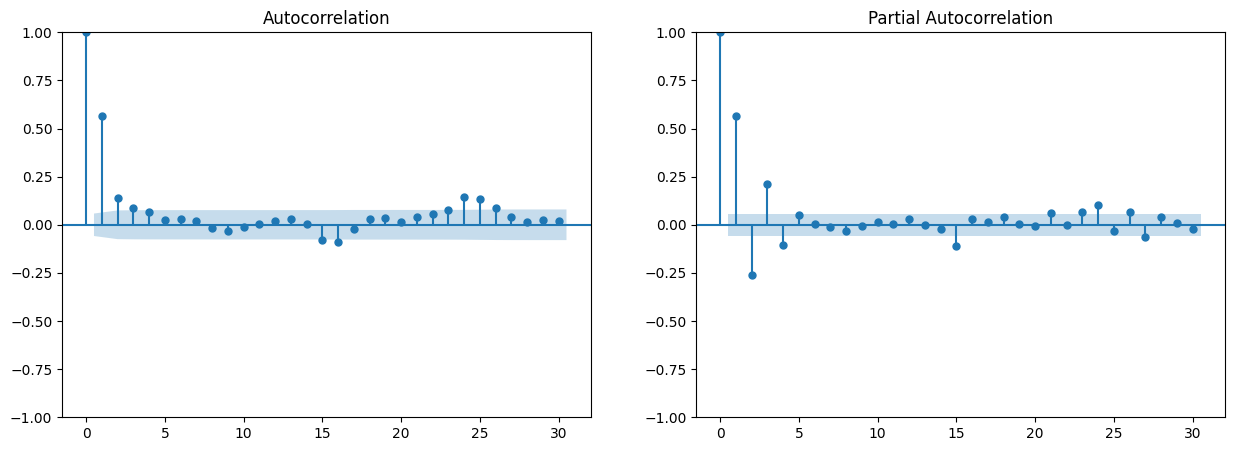

In [ ]:
residual_diag(residuals)

### 3) 결과 시각화

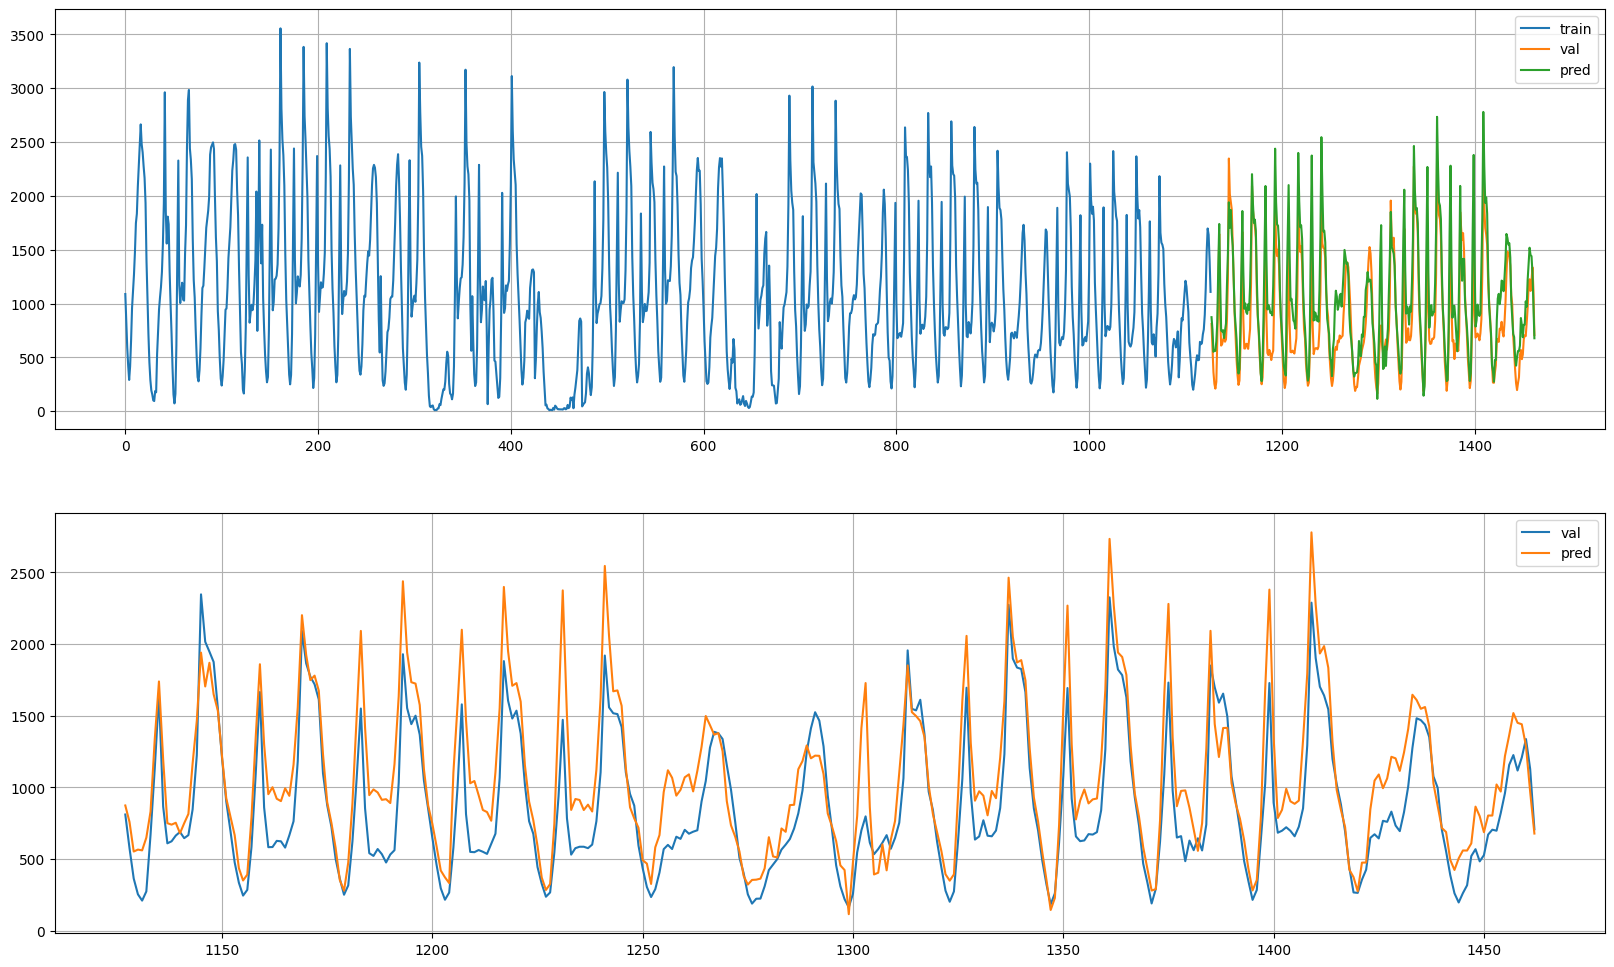

In [ ]:
plot_model_result(y_train, y_val, pred)